<a href="https://colab.research.google.com/github/YueShen220/proj-vis-eff/blob/main/Model_Training(Backend).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VFX Group Project
#### Coding details inspired from https://github.com/MuhammadHananAsghar/Hand_Gestures_Classification

## Import libraries and retreive 2D gesture dataset

In [ ]:
# Mount your Google Drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True) # (may add) force_remount=True

Mounted at /content/drive


In [ ]:
# Unzip the compressed folder on drive
!unzip /content/drive/MyDrive/shuffled_leapGestRecog.zip # > /dev/null
!ls /content/shuffled_leapGestRecog

In [ ]:
# Set up Tensorflow framework
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Load and preprocess data

In [ ]:
### Load using tf.keras.preprocessing
## Create a dataset
# Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width  = 180

In [ ]:
# Use a validation split. (80% of the images for training and 20% for validation)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/shuffled_leapGestRecog',  #data_dir
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/shuffled_leapGestRecog',  #data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20000 files belonging to 10 classes.
Using 4000 files for validation.


In [ ]:
# See labels from class names (output should be a list of labels)
class_names = train_ds.class_names
print(class_names)

['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


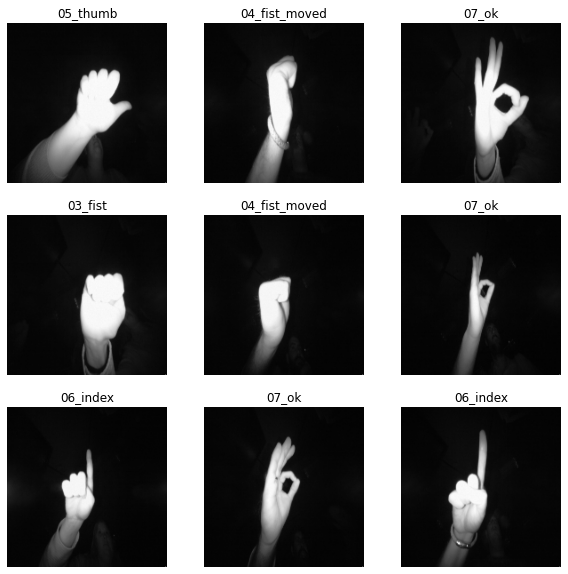

In [ ]:
# Visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Manually iterate over the dataset and retrieve batches of images (tensor of shape)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
## Standardize the data (doing this because the RGB values is not ideal for neural networks)
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
# Use the layer
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0054470357 0.98921597


In [ ]:
## Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Data augmentation to avoid overfitting
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

## Train and evaluate a CNN model

In [ ]:
## Train a model
num_classes = 10

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1000, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

checkpoint = ModelCheckpoint("gesture_recognition.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose = 1)

earlystop = EarlyStopping(monitor="val_loss",
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True)

callbacks = [earlystop, checkpoint]

epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/100
500/500 [==============================] - 790s 2s/step - loss: 0.4633 - accuracy: 0.8454 - val_loss: 0.0457 - val_accuracy: 0.9858

Epoch 00001: val_loss improved from inf to 0.04573, saving model to gesture_recognition.h5
Epoch 2/100
500/500 [==============================] - 781s 2s/step - loss: 0.0773 - accuracy: 0.9758 - val_loss: 0.0280 - val_accuracy: 0.9908

Epoch 00002: val_loss improved from 0.04573 to 0.02805, saving model to gesture_recognition.h5
Epoch 3/100
500/500 [==============================] - 778s 2s/step - loss: 0.0545 - accuracy: 0.9823 - val_loss: 0.0126 - val_accuracy: 0.9955

Epoch 00003: val_loss improved from 0.02805 to 0.01262, saving model to gesture_recognition.h5
Epoch 4/100
500/500 [==============================] - 781s 2s/step - loss: 0.0319 - accuracy: 0.9897 - val_loss: 0.0239 - val_accuracy: 0.9887

Epoch 00004: val_loss did not improve from 0.01262
Epoch 5/100
500/500 [==============================] - 778s 2s/step - loss: 0.0309 - acc

In [ ]:
## FAILED JUST BECAUSE I DID NOT SAVE THE HISTORY WHEN TRAINING MODEL

# Plot the training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

NameError: ignored

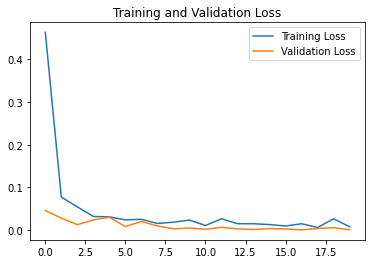

In [ ]:
# Plot the training and validation loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save and load the model

In [ ]:
# Load model from h5
def createModel():
    data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal",
                                                         input_shape=(180,
                                                                      180,
                                                                      3)),
            layers.experimental.preprocessing.RandomRotation(0.1),
            layers.experimental.preprocessing.RandomZoom(0.1),
        ]
    )

    modelBuilt = Sequential([
        data_augmentation,
        layers.experimental.preprocessing.Rescaling(1. / 255),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(1000, activation='relu'),
        layers.Dense(10)
    ])

    modelBuilt.compile(
        optimizer='adam',
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

    return modelBuilt


model = createModel()
model.load_weights("/content/drive/MyDrive/model_keras/model_keras.h5")

In [ ]:
# Save the Keras model to h5 and json files
model_json = model.to_json()
with open("model_keras.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_keras.h5")

In [ ]:
# Save the model to a pickle file
import pickle
pickle.dump(model.get_weights(), open('model_pickle.pkl','wb'))

In [ ]:
## DO NOT EXECUTE THIS FOR NOW (because the model loaded is a list, cannot predict)
## REVISION NEEDED!

# Load the pickle file
model = pickle.load(open('model_pickle.pkl','rb'))

## Deployment

In [ ]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

[INFO] loading face detector model...


NameError: ignored

## Test the model created

This image most likely belongs to 01_palm with a 99.34 percent confidence.


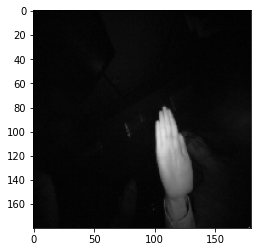

In [ ]:
# Test the model
img = keras.preprocessing.image.load_img(
    '/content/shuffled_leapGestRecog/01_palm/frame_00_01_0001.png', target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 07_ok with a 100.00 percent confidence.


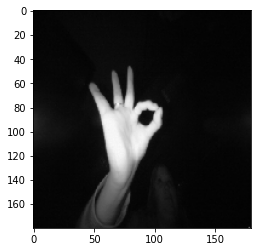

In [ ]:
# Test the model
img = keras.preprocessing.image.load_img(
    '/content/shuffled_leapGestRecog/07_ok/frame_02_07_0085.png', target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 10_down with a 99.79 percent confidence.


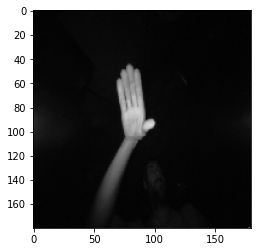

In [ ]:
# Test the model
img = keras.preprocessing.image.load_img(
    '/content/shuffled_leapGestRecog/10_down/frame_03_10_0163.png', target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 01_palm with a 100.00 percent confidence.


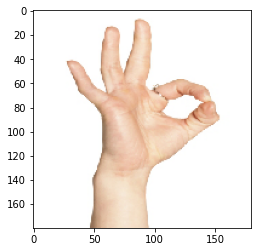

In [ ]:
# Test the model (NOT ACCURATE!)
test0='/content/drive/MyDrive/test_0.jpg'
test1='/content/drive/MyDrive/test1.jpeg'
test2='/content/drive/MyDrive/test2.jpg'
test3='/content/drive/MyDrive/test3.jpg'
img = keras.preprocessing.image.load_img(
    test0, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)